# Notebook 32: Assigning SFR and [Fe/H] to galaxies sampled from the GSMF

This notebook generates figures 1 and 10 of de Sá, Bernardo et al. (2024).

## Prelude

In [1]:
import astropy.units as u
from astropy.cosmology import WMAP9 as cosmo
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import norm

import sys
sys.path.append('../src')
from bossa.sampling import GalaxyGrid
from bossa.utils import ZOH_to_FeH, ZOH_to_FeH2, ZOH_from_FeH, FeH_to_Z
from bossa.constants import LOGE, LN10, GALAXYGRID_DIR_PATH

In [2]:
plt.style.use('./plotstyle.mplstyle')
FIGURE_FOLDER = Path('./figures')

In [3]:
llim_feh = -2.25
ulim_feh = 0.45
llim_zoh = ZOH_from_FeH(llim_feh)
ulim_zoh = ZOH_from_FeH(ulim_feh)

In [4]:
logm_min = 6
logm_max = 12

In [5]:
highmet_MZR = 'KK04'
highmet_SFMR = 'none'
highmet_GSMF_fixedslope =  True

midmet_MZR = 'M09'
midmet_SFMR = 'moderate'
midmet_GSMF_fixedslope =  True

lowmet_MZR = 'PP04'
lowmet_SFMR = 'sharp'
lowmet_GSMF_fixedslope =  True

### Background plot

In [6]:
n_redshift = 11
redshift_min = 0
redshift_max = 10
force_boundary_redshift = False
logm_min = 6
logm_max = 12
logm_per_redshift = 200

mzr_model = midmet_MZR
sfmr_flattening = midmet_SFMR
gsmf_slope_fixed = midmet_GSMF_fixedslope
sampling_mode = 'uniform' # uniform, mass or number
include_scatter = False
random_state = 42

In [7]:
bg_galaxysampling = GalaxyGrid(n_redshift,
                            redshift_min,
                            redshift_max,
                            logm_per_redshift,
                            logm_min, 
                            logm_max, 
                            mzr_model, 
                            sfmr_flattening,
                            gsmf_slope_fixed,
                            sampling_mode,
                            include_scatter,
                            random_state)

ValueError: mzr_model must be one of ['KK04', 'T04', 'M09', 'PP04'].

In [ ]:
%%time
bg_galaxysampling.get_grid()

In [ ]:
bg_logm_bins = bg_galaxysampling.galaxy_sample.bin_limits
bg_logms = bg_galaxysampling.galaxy_sample.grid_logmasses
bg_zs = bg_galaxysampling.sample_redshift_array
bg_zoh_array = np.array(bg_galaxysampling.zoh_list)
bg_zoh_list = bg_galaxysampling.zoh_list
bg_sfr_array = np.array(bg_galaxysampling.sfr_list)
bg_sfr_list = bg_galaxysampling.sfr_list
bg_log_gsmf_list = bg_galaxysampling.log_gsmf_list
bg_log_gsmf_array = np.array(bg_log_gsmf_list)
bg_log_gsmf_max = np.concatenate(bg_log_gsmf_list).max()
bg_log_gsmf_min = np.concatenate(bg_log_gsmf_list).min()
bg_log_gsmf_cnorm = bg_log_gsmf_max - bg_log_gsmf_min

In [ ]:
bg_density_array = bg_galaxysampling.density_array
bg_ndensity_array = bg_galaxysampling.ndensity_array
bg_dzoh_lims_array = bg_galaxysampling.zoh_bin_array
bg_sample_redshift_array = bg_galaxysampling.sample_redshift_array

In [ ]:
bg_logm_bin_size = np.array([np.log10(10**logm1 - 10**logm0) for logm0,logm1 in zip(bg_logm_bins[1:], bg_logm_bins[:-1])])

In [ ]:
bg_mass_distr = 2*bg_logm_bin_size+bg_log_gsmf_list

In [ ]:
fig, ax = plt.subplots(figsize=(14,8))

for z, sublist in zip(bg_sample_redshift_array, bg_mass_distr):
    c = cm.viridis(z/10)
    ax.step(bg_logms, sublist, label=f'$z={z:.1f}$', c=c)
    
ax.set_xlabel(r'$M_\ast\,\left(\mathrm{M}_\odot\right)$')
ax.set_xlim(6, 12)
ax.set_ylabel(r'$\log\left(M_{\ast,\mathrm{tot}}/\mathrm{M}_\odot\right)$')

ax.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')

In [ ]:
fig, ax = plt.subplots(figsize=(18,6), tight_layout=True)
zoh_minplot = 4.2
zoh_maxplot = 9.5
sfr_minplot = -2.8
sfr_maxplot = 4.2
bg_log_gsmf_max = np.concatenate(bg_log_gsmf_list).max()
bg_log_gsmf_min = np.concatenate(bg_log_gsmf_list).min()
bg_cnorm = bg_log_gsmf_max - bg_log_gsmf_min
z_cnorm = bg_sample_redshift_array.max() - bg_sample_redshift_array.min()

for z, zohs, sfrs in zip(bg_zs, bg_zoh_array, bg_sfr_array):
    ax.plot(zohs, sfrs, '.', c='gray', markersize=5, lw=2, alpha=0.1)

bg_mass_min = np.concatenate(bg_mass_distr).min()
bg_mass_max = np.concatenate(bg_mass_distr).max()
bg_cnorm = bg_mass_max - bg_mass_min
for z, zohs, sfrs, mass in zip(bg_zs, bg_zoh_list, bg_sfr_list, bg_mass_distr):
    c = (mass - bg_mass_min) / bg_cnorm
    ax.scatter(zohs, sfrs, c=c, cmap='viridis', vmin=0, vmax=1)
    ax.text(zohs[-2]-0.2, sfrs[-2]-0.2, f'z={z:.0f}', fontsize=10)

ax.set_ylabel(r'$\log\left(\mathrm{SFR\left[\mathrm{M}_\odot\,\mathrm{yr}^{-1}\right]}\right)$')
ax.set_ylim(sfr_minplot, sfr_maxplot)

ax.set_xticks(np.arange(4,10,1))
ax.set_xlim(zoh_minplot-0.1, zoh_maxplot-0.3)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$')

ax2 = ax.twiny()
ax2.set_xticks(np.arange(4,10,1))
ax2.set_xlim(zoh_minplot-0.1, zoh_maxplot-0.3)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(4,10,1)]])
ax2.set_xlabel('[Fe/H]')

ax.tick_params(axis='both', direction='in')
ax2.tick_params(axis='x', direction='in')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=bg_mass_min, vmax=bg_mass_max))
cb = fig.colorbar(sm)
cb.set_label(r'$\log\left(\Delta M_{\ast,\mathrm{tot}}/\mathrm{M}_\odot\right)$')

#plt.savefig(FIGURE_FOLDER/'sfrgrid_bg.png')

## Sampling galaxies from the GSMF

Generate the sample.

In [ ]:
n_redshift = 11
redshift_min = 0
redshift_max = 10
logm_per_redshift = 10
logm_min = 6
logm_max = 12
mzr_model = midmet_MZR
sfmr_flattening = midmet_SFMR
gsmf_slope_fixed = midmet_GSMF_fixedslope
sampling_mode = 'mass' # uniform, mass or number
include_scatter = False
random_state = 42

In [ ]:
galaxysampling = GalaxyGrid(n_redshift,
                            redshift_min,
                            redshift_max,
                            logm_per_redshift,
                            logm_min, 
                            logm_max, 
                            mzr_model, 
                            sfmr_flattening,
                            gsmf_slope_fixed,
                            sampling_mode,
                            include_scatter,
                            random_state)

In [ ]:
%%time
galaxysampling.get_grid()

In [ ]:
zoh_list = galaxysampling.zoh_list
feh_list = galaxysampling.feh_list
sfr_list = galaxysampling.sfr_list
log_gsmf_list = galaxysampling.log_gsmf_list
gsmf_list = [10.**log_gsmf for log_gsmf in log_gsmf_list]
mass_list = galaxysampling.mass_list
sample_redshift_array = galaxysampling.sample_redshift_array

fig, ax = plt.subplots(figsize=(18,6), tight_layout=True)
zoh_minplot = 4.2
zoh_maxplot = 9.5
sfr_minplot = -2.8
sfr_maxplot = 4.2
log_gsmf_max = np.concatenate(log_gsmf_list).max()
log_gsmf_min = np.concatenate(log_gsmf_list).min()
cnorm = log_gsmf_max - log_gsmf_min
z_cnorm = sample_redshift_array.max() - sample_redshift_array.min()

for z, zohs, sfrs in zip(bg_zs, bg_zoh_array, bg_sfr_array):
    ax.plot(zohs, sfrs, '.', c='gray', markersize=5, lw=2, alpha=0.1)
    
for z, zohs, sfrs, mass in zip(bg_zs, bg_zoh_list, bg_sfr_list, bg_mass_distr):
    c = (mass - bg_mass_min) / bg_cnorm
    ax.scatter(zohs, sfrs, c=c, cmap='viridis', vmin=0, vmax=1)
    ax.text(zohs[-2]-0.2, sfrs[-2]-0.2, f'z={z:.0f}', fontsize=10)

grid_descr = ''
for z, masses, zohs, sfrs in zip(sample_redshift_array, mass_list, zoh_list, sfr_list):
    color = cm.jet((z-sample_redshift_array.min())/z_cnorm)
    ax.plot(zohs, sfrs, '*', c='magenta', markersize=10, lw=2)
    line = ''.join([r'$\log\left(M_i/M_\odot\right)$ = {}'.format(masses)]+[' \n'])
    grid_descr += line
    
for feh in np.arange(-5, 1, 1):
    zoh = ZOH_from_FeH(feh)
    ax.vlines(zoh, -3, 5, linestyle='--', color='orange', linewidth=1)
    ax.text(zoh+0.01, -2.8, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', c='orange', fontsize=18)
    
ax.set_ylabel(r'$\log\left[\mathrm{SFR}/\left(\mathrm{M}_\odot\,\mathrm{yr}^{-1}\right)\right]$')
ax.set_ylim(sfr_minplot, sfr_maxplot-0.8)

ax.set_xticks(np.arange(4,10,1))
ax.set_xlim(zoh_minplot-0.2, zoh_maxplot-0.3)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$')

ax2 = ax.twiny()
ax2.set_xticks(np.arange(4,10,1))
ax2.set_xlim(zoh_minplot-0.1, zoh_maxplot-0.3)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(4,10,1)]])
ax2.set_xlabel('[Fe/H]')

ax.tick_params(axis='both', direction='in')
ax2.tick_params(axis='x', direction='in')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=bg_mass_min, vmax=bg_mass_max))
cb = fig.colorbar(sm)
cb.set_label(r'$\log\left(\Delta M_{\ast,\mathrm{tot}}/\mathrm{M}_\odot\right)$')

plt.savefig(FIGURE_FOLDER/'sfrgrid_midmet_uniformz.png')

#### Metallicity distribution

In [ ]:
feh_array = np.empty(bg_zoh_array.shape, np.float64)
for i, row in enumerate(bg_zoh_array):
    for j, zoh in enumerate(row):
        feh = ZOH_to_FeH(zoh)
        feh_array[i,j] = feh

In [ ]:
feh_array2 = np.empty(bg_zoh_array.shape, np.float64)
for i, row in enumerate(bg_zoh_array):
    for j, zoh in enumerate(row):
        feh = ZOH_to_FeH2(zoh)
        feh_array2[i,j] = feh

In [ ]:
dFeH_lims_array = np.empty(bg_dzoh_lims_array.shape, np.float64)
dFeH_array = np.empty((bg_dzoh_lims_array.shape[0], bg_dzoh_lims_array.shape[1]-1), np.float64)

for i, row in enumerate(bg_dzoh_lims_array):
    for j, zoh in enumerate(row):
        FeH = ZOH_to_FeH(zoh)
        dFeH_lims_array[i,j] = FeH
        
for i, row in enumerate(dFeH_lims_array):
    for j, (FeH1, FeH2) in enumerate(zip(row[:-1], row[1:])):
        dFeH = np.abs(FeH2 - FeH1)
        dFeH_array[i,j] = dFeH

In [ ]:
dFeH_lims_array2 = np.empty(bg_dzoh_lims_array.shape, np.float64)
dFeH_array2 = np.empty((bg_dzoh_lims_array.shape[0], bg_dzoh_lims_array.shape[1]-1), np.float64)

for i, row in enumerate(bg_dzoh_lims_array):
    for j, zoh in enumerate(row):
        FeH = ZOH_to_FeH2(zoh)
        dFeH_lims_array2[i,j] = FeH
        
for i, row in enumerate(dFeH_lims_array2):
    for j, (FeH1, FeH2) in enumerate(zip(row[:-1], row[1:])):
        dFeH = np.abs(FeH2 - FeH1)
        dFeH_array2[i,j] = dFeH

In [ ]:
dndFeH_array = np.divide(bg_density_array, dFeH_array)

In [ ]:
dndFeH_array2 = np.divide(bg_density_array, dFeH_array2)

In [ ]:
dNdFeH_array = np.empty(dndFeH_array.shape, np.float64)

for i, (z, row) in enumerate(zip(bg_sample_redshift_array, dndFeH_array)):
    dVc = (4*np.pi*u.sr * cosmo.differential_comoving_volume(z)).value
    for j, dndFeH in enumerate(row):
        dNdFeH = dndFeH * dVc
        dNdFeH_array[i,j] = dNdFeH

In [ ]:
dNdFeH_array2 = np.empty(dndFeH_array2.shape, np.float64)

for i, (z, row) in enumerate(zip(bg_sample_redshift_array, dndFeH_array2)):
    dVc = (4*np.pi*u.sr * cosmo.differential_comoving_volume(z)).value
    for j, dndFeH in enumerate(row):
        dNdFeH = dndFeH * dVc
        dNdFeH_array2[i,j] = dNdFeH

In [ ]:
normalized_dNdFeH_array = np.empty(dNdFeH_array.shape, np.float64)

for i, (row, dFeH_lims) in enumerate(zip(dNdFeH_array, dFeH_lims_array)):
    intt = 0
    for dNdFeH, llim, ulim in zip(row, dFeH_lims[:-1], dFeH_lims[1:]):
        dFeH = np.abs(ulim - llim)
        dN = dNdFeH * dFeH
        intt += dN
    normalized_row = row / row.sum()
    if intt != 0:
        normalized_row = row / intt
    normalized_dNdFeH_array[i] = normalized_row

In [ ]:
normalized_dNdFeH_array2 = np.empty(dNdFeH_array2.shape, np.float64)

for i, row in enumerate(dNdFeH_array2):
    normalized_row = row / row.sum()
    normalized_dNdFeH_array2[i] = normalized_row

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
dNdFeH_plot_cnorm = bg_sample_redshift_array.max() - bg_sample_redshift_array.min()

for z, fehs, dNdFeHs in zip(bg_sample_redshift_array, feh_array, dNdFeH_array):
    color = cm.viridis((z-bg_sample_redshift_array.min())/dNdFeH_plot_cnorm)
    ax.plot(fehs, dNdFeHs, c=color, label=f'z = {z:.1f}')
    
ax.set_xlabel('[Fe/H]', fontsize=18)
ax.set_ylabel(r'$\left(\mathrm{d}M_\mathrm{SFR}/\mathrm{d[Fe/H]}\right)/M_\mathrm{SFR}(z)$', fontsize=18)
ax.tick_params(axis='both', direction='in', labelsize=14)
ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1, 1), loc='upper left', frameon=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
dNdFeH_plot_cnorm = sample_redshift_array.max() - sample_redshift_array.min()

for z, fehs, dNdFeHs in zip(sample_redshift_array, feh_array2, normalized_dNdFeH_array2):
    color = cm.viridis((z-sample_redshift_array.min())/dNdFeH_plot_cnorm)
    ax.plot(fehs, dNdFeHs, ':', c=color, lw=2, markersize=16)

for z, fehs, dNdFeHs in zip(sample_redshift_array, feh_array, normalized_dNdFeH_array):
    color = cm.viridis((z-sample_redshift_array.min())/dNdFeH_plot_cnorm)
    ax.plot(fehs, dNdFeHs, '-', c=color, label=f'z = {z:.1f}', lw=2, markersize=16)
    
ax.set_xlabel('[Fe/H]', fontsize=24)
ax.set_ylabel(r'$\mathcal{P}\left(\mathrm{[Fe/H]}\right)$', fontsize=24)
ax.tick_params(axis='both', direction='in', labelsize=18)
    
ax.legend(loc='upper left', frameon=False, fontsize=18)
plt.savefig('zdistr_lowmet.pdf')

In [ ]:
cm_cubehelix = sns.cubehelix_palette(as_cmap=True)

In [ ]:
zoh_minplot = 3.8
zoh_maxplot = 9.5
sfr_minplot = -4.2
sfr_maxplot = 4.2

fig, (ax3, ax) = plt.subplots(1, 2, figsize=(26, 8), tight_layout=True, gridspec_kw={'width_ratios': [2, 5]})
rect = fig.patch
rect.set_facecolor('white')
    
for z, zohs, sfrs, mass in zip(bg_zs, bg_zoh_list, bg_sfr_list, bg_mass_distr):
    c = (mass - bg_mass_min) / bg_cnorm
    ax.scatter(zohs, sfrs, c=c, cmap='viridis', vmin=0, vmax=1)
    if z!= 10:
        ax.text(zohs[-2]-0.05, 1.1*(sfrs[-2]), f'$z={z:.0f}$', ha='right', va='top', fontsize=18)
    else:
        ax.text(zohs[-2]-0.05, sfrs[-2]+0.05, f'$z={z:.0f}$', ha='right', va='bottom', fontsize=18)

for feh in np.arange(-5, 1, 1):
    zoh = ZOH_from_FeH(feh)
    ax.vlines(zoh, -5, 5, linestyle='--', color='orange', linewidth=1)
    ax.text(zoh+0.01, -3.9, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', color='orange', fontsize=22)
    
for z, masses, zohs, sfrs in zip(sample_redshift_array, mass_list, zoh_list, sfr_list):
    ax.plot(zohs, sfrs, '*', c='magenta', markersize=13, lw=2)
    
ax.set_ylabel(r'$\log\left[\mathrm{SFR}\,(\mathrm{M}_\odot\,\mathrm{yr}^{-1})\right]$')
ax.set_ylim(sfr_minplot, sfr_maxplot)

ax.set_xticks(np.arange(4,10,1))
ax.set_xlim(zoh_minplot, zoh_maxplot)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$')

ax2 = ax.twiny()
ax2.set_xticks(np.arange(4,10,1))
ax2.set_xlim(zoh_minplot, zoh_maxplot)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(4,10,1)]])
ax2.set_xlabel('[Fe/H]')

ax.tick_params(axis='both', direction='in')
ax2.tick_params(axis='x', direction='in')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=bg_log_gsmf_min, vmax=bg_log_gsmf_max))
cb = fig.colorbar(sm)
cb.set_label(r'$\log\left[\Phi/\left(\mathrm{Mpc}^{-3}\,\mathrm{M}_\odot^{-1}\right)\right]$')

dNdFeH_plot_cnorm = sample_redshift_array.max() - sample_redshift_array.min()

zi = 0
for z, fehs, dNdFeHs in zip(sample_redshift_array[::2], feh_array[::2], normalized_dNdFeH_array[::2]):
    color = cm_cubehelix(zi/len(sample_redshift_array[::2]))
    ax3.plot(fehs, dNdFeHs, '-', c=color, label=f'z = {z:.0f}', lw=3, markersize=16)
    zi += 1
    
ax3.set_xlabel('[Fe/H]')
ax3.set_ylabel(r'$\mathcal{P}\left(\mathrm{[Fe/H]}\right)$')
ax3.tick_params(axis='both', direction='in')
    
ax3.legend(loc='upper left', frameon=False)
ax3.set_xlim(-5.6, 0.4)
ax3.set_ylim(0, 1.9)

plt.savefig(FIGURE_FOLDER/'example_sfrgrid.pdf', bbox_inches='tight')

## Saving the grid

#### The above grid

In [ ]:
EXAMPLE_GRIDFILE = Path(GALAXYGRID_DIR_PATH, 'sfrgrid_example.pkl')

In [ ]:
n_columns = 6 # redshift, galaxy mass, density, sfr, zoh, feh
columns = ['Redshift', 'Log(Mgal/Msun)', 'Log(Number density [Mpc-3 Msun-1])', 'Log(SFR [Msun yr-1])', '12+log(O/H)', '[Fe/H]']

grid_array = np.empty((0, n_columns), np.float64)
for z, masses, densities, sfrs, zohs, fehs in zip(sample_redshift_array, mass_list, gsmf_list,  sfr_list, zoh_list, feh_list):
    lines = np.array([masses, densities, sfrs, zohs, fehs], np.float64).T
    for line in lines:
        grid_array = np.append(grid_array, [np.concatenate(([np.float64(z)], line))], axis=0)

grid_df = pd.DataFrame(grid_array, columns=columns)

In [ ]:
grid_df.describe()

In [ ]:
with plt.rc_context({'axes.labelsize': 12}):
    sns.pairplot(grid_df, hue='Redshift')

In [ ]:
grid_df.info()

#### A SFR-uniform square grid

In [6]:
sfrsq_list = np.array([-2, -1, 0, 1, 2, 3])

In [7]:
sfrsq_met_list = np.arange(-5, 2, 1)
sfrsq_met_list = np.tile(sfrsq_met_list, (len(sfrsq_list),1))

In [8]:
n_columns = 2 # sfr feh
columns = ['Log(SFR [Msun yr-1])', '[Fe/H]']

sfrsq_grid_array = np.empty((0, n_columns), np.float64)
for sfr, fehs in zip(sfrsq_list, sfrsq_met_list):
    lines = np.array([fehs], np.float64).T
    for line in lines:
        sfrsq_grid_array = np.append(sfrsq_grid_array, [np.concatenate(([np.float64(sfr)], line))], axis=0)

sfrsq_grid_df = pd.DataFrame(sfrsq_grid_array, columns=columns)

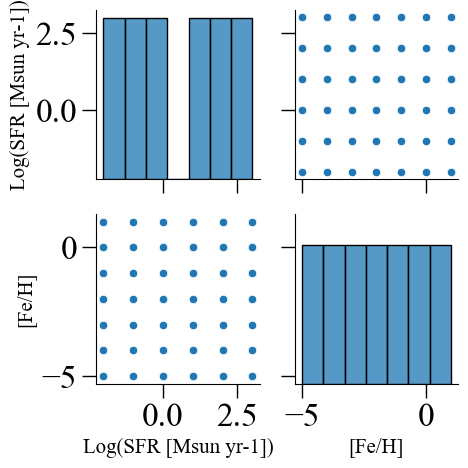

In [9]:
with plt.rc_context({'axes.labelsize': 15}):
    sns.pairplot(sfrsq_grid_df)

#### A redshift-uniform square grid

In [10]:
n_redshift = 11
redshift_min = 0
redshift_max = 10
force_boundary_redshift = False
logm_per_redshift = 10
logm_min = 6
logm_max = 12
mzr_model = midmet_MZR
sfmr_flattening = midmet_SFMR
gsmf_slope_fixed = midmet_GSMF_fixedslope
sampling_mode = 'uniform' # uniform, mass or number
scatter_model = 'none'
apply_igimf_corrections = True
random_state = 42

In [11]:
zsq_galaxysampling = GalaxyGrid(n_redshift=n_redshift,
                                redshift_min=redshift_min,
                                redshift_max=redshift_max,
                                force_boundary_redshift=force_boundary_redshift,
                                logm_per_redshift=logm_per_redshift,
                                logm_min=logm_min,
                                logm_max=logm_max,
                                mzr_model=mzr_model,
                                sfmr_flattening=sfmr_flattening,
                                gsmf_slope_fixed=gsmf_slope_fixed,
                                sampling_mode=sampling_mode,
                                scatter_model=scatter_model,
                                apply_igimf_corrections=apply_igimf_corrections,
                                random_state=random_state)

In [12]:
%%time
zsq_galaxysampling.get_sample()

CPU times: user 2.35 s, sys: 3.34 ms, total: 2.36 s
Wall time: 2.36 s


In [15]:
fig, ax = plt.subplots(figsize=(18,6), tight_layout=True)
zoh_minplot = 4.2
zoh_maxplot = 9.5
sfr_minplot = -2.8
sfr_maxplot = 4.2
log_gsmf_max = np.concatenate(log_gsmf_list).max()
log_gsmf_min = np.concatenate(log_gsmf_list).min()
cnorm = log_gsmf_max - log_gsmf_min
z_cnorm = sample_redshift_array.max() - sample_redshift_array.min()

for z, zohs, sfrs in zip(bg_zs, bg_zoh_array, bg_sfr_array):
    ax.plot(zohs, sfrs, '.', c='gray', markersize=5, lw=2, alpha=0.1)
    
for z, zohs, sfrs, mass in zip(bg_zs, bg_zoh_list, bg_sfr_list, bg_mass_distr):
    c = (mass - bg_mass_min) / bg_cnorm
    ax.scatter(zohs, sfrs, c=c, cmap='viridis', vmin=0, vmax=1)
    ax.text(zohs[-2]-0.2, sfrs[-2]-0.2, f'z={z:.0f}', fontsize=10)

grid_descr = ''
for z, masses, zohs, sfrs in zip(sample_redshift_array, mass_list, zoh_list, sfr_list):
    color = cm.jet((z-sample_redshift_array.min())/z_cnorm)
    ax.plot(zohs, sfrs, '*', c='magenta', markersize=10, lw=2)
    line = ''.join([r'$\log\left(M_i/M_\odot\right)$ = {}'.format(masses)]+[' \n'])
    grid_descr += line
    
for feh in np.arange(-5, 1, 1):
    zoh = ZOH_from_FeH(feh)
    ax.vlines(zoh, -3, 5, linestyle='--', color='orange', linewidth=1)
    ax.text(zoh+0.01, -2.8, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', c='orange', fontsize=18)
        
ax.set_ylabel(r'$\log\left[\mathrm{SFR}/\left(\mathrm{M}_\odot\,\mathrm{yr}^{-1}\right)\right]$')
ax.set_ylim(sfr_minplot, sfr_maxplot-0.8)

ax.set_xticks(np.arange(4,10,1))
ax.set_xlim(zoh_minplot-0.2, zoh_maxplot-0.3)
ax.set_xlabel(r'$12+\log\left(\mathrm{O/H}\right)$')

ax2 = ax.twiny()
ax2.set_xticks(np.arange(4,10,1))
ax2.set_xlim(zoh_minplot-0.1, zoh_maxplot-0.3)
ax2.set_xticklabels([f'{x:.2f}' for x in [ZOH_to_FeH(zoh) for zoh in np.arange(4,10,1)]])
ax2.set_xlabel('[Fe/H]')

ax.tick_params(axis='both', direction='in')
ax2.tick_params(axis='x', direction='in')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=bg_mass_min, vmax=bg_mass_max))
cb = fig.colorbar(sm)
cb.set_label(r'$\log\left(\Delta M_{\ast,\mathrm{tot}}/\mathrm{M}_\odot\right)$')

<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\o'
<>:37: SyntaxWarning: invalid escape sequence '\,'
<>:37: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipykernel_616709/350069396.py:37: SyntaxWarning: invalid escape sequence '\,'
  ax.text(zoh+0.01, -2.8, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', c='orange', fontsize=18)
/tmp/ipykernel_616709/350069396.py:37: SyntaxWarning: invalid escape sequence '\o'
  ax.text(zoh+0.01, -2.8, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', c='orange', fontsize=18)
/tmp/ipykernel_616709/350069396.py:37: SyntaxWarning: invalid escape sequence '\,'
  ax.text(zoh+0.01, -2.8, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', c='orange', fontsize=18)
/tmp/ipykernel_616709/350069396.py:37: SyntaxWarning: invalid escape sequence '\o'
  ax.text(zoh+0.01, -2.8, f'$10^{{{feh}}}\,\mathrm{{Z}}_\odot$', va='bottom', ha='left', c='orange', fontsize=18)


NameError: name 'bg_zs' is not defined

In [34]:
sample_redshift_array = zsq_galaxysampling.sample_redshift_array
mass_list = zsq_galaxysampling.mass_list
zoh_list = zsq_galaxysampling.zoh_list
feh_list = zsq_galaxysampling.feh_list
sfr_list = zsq_galaxysampling.sfr_list
log_gsmf_list = zsq_galaxysampling.log_gsmf_list
gsmf_list = [10.**log_gsmf for log_gsmf in log_gsmf_list]

In [35]:
n_columns = 6 # redshift, galaxy mass, density, sfr, zoh, feh
columns = ['Redshift', 'Log(Mgal/Msun)', 'Log(Number density [Mpc-3 Msun-1])', 'Log(SFR [Msun yr-1])', '12+log(O/H)', '[Fe/H]']

zsq_grid_array = np.empty((0, n_columns), np.float64)
for z, masses, densities, sfrs, zohs, fehs in zip(sample_redshift_array, mass_list, gsmf_list,  sfr_list, zoh_list, feh_list):
    lines = np.array([masses, densities, sfrs, zohs, fehs], np.float64).T
    for line in lines:
        zsq_grid_array = np.append(zsq_grid_array, [np.concatenate(([np.float64(z)], line))], axis=0)

zsq_grid_df = pd.DataFrame(zsq_grid_array, columns=columns)

In [36]:
zsq_grid_df.describe()

,Redshift,Log(Mgal/Msun),Log(Number density [Mpc-3 Msun-1]),Log(SFR [Msun yr-1]),12+log(O/H),[Fe/H]
count,110.00000,110.000000,1.100000e+02,110.000000,110.000000,110.000000
mean,5.00000,8.990067,9.103771e-03,0.394791,7.221657,-2.020808
std,3.17675,1.715369,2.291437e-02,1.150983,1.150265,1.288705
min,0.00000,6.298500,1.574912e-14,-2.127792,4.483863,-4.846137
25%,2.00000,7.503000,2.068080e-05,-0.530955,6.436313,-2.893687
50%,5.00000,9.003000,4.410273e-04,0.387125,7.248620,-2.081380
75%,8.00000,10.497000,5.729006e-03,1.285419,8.057039,-1.272961
max,10.00000,11.704500,1.573304e-01,2.510635,9.073650,0.487300


## IMF grids

#### Redshift-uniform IMF grid

In [37]:
from bossa.imf import IGIMF

In [38]:
def kroupa(m):
    if m < 0.5:
        return 2*m**-1.3
    else:
        return m**-2.3

In [39]:
plot_ms = np.concatenate(([0.07],
                          np.linspace(0.08, 149, 100),
                          [150]))# increase plot_ms resolution to improve plot quality

In [40]:
igimf = IGIMF(1, 0)

In [41]:
igimf.set_clusters()

In [42]:
igimf._get_stars(5000, 1)

125.34494952946939

In [43]:
from bossa.imf import Star, PowerLawIMF

In [44]:
stellar = Star(m_ecl=5000, feh=0)
stellar.get_mmax_k()

In [45]:
stellar.breaks

array([8.00000000e-02, 5.00000000e-01, 1.00000000e+00, 1.43433615e+02])

In [46]:
m = 1
index, m_break = (next(((i, break_) for i, break_ in enumerate(stellar.breaks) if break_ > m),
                  (len(stellar.breaks), stellar.m_trunc_max)))

In [47]:
index, m_break

(3, 143.4336154255255)

In [48]:
stellar.imf(1)

125.34494952946939

In [ ]:
zsq_plot_igimfs = []
zsq_plot_zs = []
zsq_plot_fehs = []
zsq_plot_logsfrs = []

for redshift in np.unique(zsq_grid_df['Redshift']):   
    zsq_plot_zs.append(redshift)
    print(f'Now working for z={redshift}')
    subdf = zsq_grid_df[zsq_grid_df['Redshift'] == redshift]
    feh_logsfr = subdf[['[Fe/H]', 'Log(SFR [Msun yr-1])']].to_numpy()
    feh_logsfr = feh_logsfr[np.argsort(feh_logsfr[:,0])]
    #feh_logsfr = feh_logsfr[feh_logsfr[:,0] > -2.5]
    step = len(feh_logsfr)//10
    if step == 0 :
        step = 1
    feh_logsfr = feh_logsfr[::step]
    igimfs = []
    fehs = []
    logsfrs = []
    for feh, logsfr in feh_logsfr:
        fehs.append(feh)
        logsfrs.append(logsfr)
        print(f'Now working for feh={feh:.3f} logsfr={logsfr:.3f}')
        igimf = IGIMF(10**logsfr, feh)
        igimf.set_clusters()
        igimf_arr = np.array([igimf.imf(m) for m in plot_ms])
        igimfs.append(igimf_arr)
    print('')
    zsq_plot_fehs.append(fehs)
    zsq_plot_logsfrs.append(logsfrs)
    zsq_plot_igimfs.append(igimfs)

Now working for z=0.0
Now working for feh=-2.115 logsfr=-2.128


/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/scipy/stats/_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in scalar divide
  slope = ssxym / ssxm
/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/scipy/stats/_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/lucasmdesa/anaconda3/envs/bossa/lib/python3.12/site-packages/scipy/stats/_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in scalar divide
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Now working for feh=-1.746 logsfr=-1.786
Now working for feh=-1.387 logsfr=-1.435
Now working for feh=-1.050 logsfr=-1.081
Now working for feh=-0.513 logsfr=-0.690
Now working for feh=-0.069 logsfr=-0.324
Now working for feh=0.213 logsfr=-0.015
Now working for feh=0.367 logsfr=0.195
Now working for feh=0.442 logsfr=0.403
Now working for feh=0.475 logsfr=0.614

Now working for z=1.0
Now working for feh=-2.256 logsfr=-1.607
Now working for feh=-1.922 logsfr=-1.249
Now working for feh=-1.591 logsfr=-0.885
Now working for feh=-1.273 logsfr=-0.512
Now working for feh=-0.959 logsfr=-0.149
Now working for feh=-0.444 logsfr=0.234
Now working for feh=-0.039 logsfr=0.591
Now working for feh=0.237 logsfr=0.910
Now working for feh=0.400 logsfr=1.230
Now working for feh=0.487 logsfr=1.555

Now working for z=2.0
Now working for feh=-2.660 logsfr=-1.346
Now working for feh=-2.311 logsfr=-0.984
Now working for feh=-1.965 logsfr=-0.603
Now working for feh=-1.625 logsfr=-0.231
Now working for feh=-1.297

In [27]:
# 2 LINES 3 COLUMNS

fig, axes = plt.subplots(2, 3, figsize=(16, 8), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

flat_fehs = np.concatenate(np.array(zsq_plot_fehs))
cnorm = flat_fehs.max()-flat_fehs.min()


for i, (ax, igimfs, z) in enumerate(zip(axes.flatten(), zsq_plot_igimfs, zsq_plot_zs)):
    for b in np.logspace(-5, 15, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa(m) for m in ms], 'k-', lw=1, alpha=0.5)
    
    
    fehs = zsq_plot_fehs[i]
    logsfrs = zsq_plot_logsfrs[i]
    for igimf, feh, logsfr in zip(igimfs, fehs, logsfrs):
        if all(n>=0 for n in igimf):
            c = cm.viridis((np.abs(feh-flat_fehs.min()))/cnorm)
            if feh == 0 and logsfr == 0:
                c = 'red'
            else:
                ax.plot(plot_ms, igimf, label=f'{feh:.2f}, {logsfr:.2f}', c=c, lw=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylim(1e-2, 1e10)
    ax.set_yticks([10.**x for x in np.arange(-1, 10, 3)])
    ax.set_yticklabels(np.arange(-1, 10, 3))
        
    ax.set_xlim(0.05, 200)
    ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
    ax.set_xticks([], minor=True)
    ax.set_xticklabels(np.arange(-1, 3, 1))
    
    ax.text(0.95, 0.95, f'z = {z:.1f}',  ha='right', va='top', transform=ax.transAxes)

fig.text(0.52, 0.07, r'$\log\left(M/\mathrm{M}_\odot\right)$', ha='center', va='top', fontsize=30)
fig.text(0.09, 0.43, r'$\log\left[\xi_g\,\left(m|\mathrm{[Fe/H]},z\right)/(\mathrm{M}_\odot^{-1})\right]$', rotation=90, ha='right', va='center')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=flat_fehs.min(), vmax=flat_fehs.max()))
cb = fig.colorbar(sm, location='top', aspect=50, ax=axes)
cb.set_label('[Fe/H]')

fig.savefig(FIGURE_FOLDER/'redshift_imfs_upto5_thin.pdf', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'redshift_imfs_upto5_thin.png', bbox_inches='tight')

ValueError: need at least one array to concatenate

In [28]:
# 2 LINES 3 COLUMNS

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

flat_fehs = np.concatenate(np.array(zsq_plot_fehs))
cnorm = flat_fehs.max()-flat_fehs.min()


for i, (ax, igimfs, z) in enumerate(zip(axes.flatten(), zsq_plot_igimfs[::2], zsq_plot_zs[::2])):
    for b in np.logspace(-5, 15, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa(m) for m in ms], 'k-', lw=1, alpha=0.5)
    
    fehs = zsq_plot_fehs[i]
    logsfrs = zsq_plot_logsfrs[i]
    for igimf, feh, logsfr in zip(igimfs, fehs, logsfrs):
        if all(n>=0 for n in igimf):
            c = cm.viridis((np.abs(feh-flat_fehs.min()))/cnorm)
            if feh == 0 and logsfr == 0:
                c = 'red'
            else:
                ax.plot(plot_ms, igimf, label=f'{feh:.2f}, {logsfr:.2f}', c=c, lw=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylim(1e-2, 1e10)
    ax.set_yticks([10.**x for x in np.arange(-1, 10, 2)])
    ax.set_yticklabels(np.arange(-1, 10, 2))
        
    ax.set_xlim(0.05, 200)
    ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
    ax.set_xticks([], minor=True)
    ax.set_xticklabels(np.arange(-1, 3, 1))
        
    ax.text(0.95, 0.95, f'z = {z:.1f}',  ha='right', va='top', transform=ax.transAxes)

fig.text(0.52, 0.07, r'$\log\left(M/\mathrm{M}_\odot\right)$', ha='center', va='top', fontsize=30)
fig.text(0.09, 0.43, r'$\log\left[\xi_g\,\left(m|\mathrm{[Fe/H]},z\right)/(\mathrm{M}_\odot^{-1})\right]$', rotation=90, ha='right', va='center')
  
sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=flat_fehs.min(), vmax=flat_fehs.max()))
cb = fig.colorbar(sm, location='top', aspect=50, ax=axes)
cb.set_label('[Fe/H]')

fig.savefig(FIGURE_FOLDER/'redshift_imfs_upto10.pdf', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'redshift_imfs_upto10.png', bbox_inches='tight')

ValueError: need at least one array to concatenate

In [29]:
# 2 LINES 3 COLUMNS

fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharey=True, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)
rect = fig.patch
rect.set_facecolor('white')

flat_fehs = np.concatenate(np.array(zsq_plot_fehs))
cnorm = flat_fehs.max()-flat_fehs.min()


for i, (ax, igimfs, z) in enumerate(zip(axes.flatten(), zsq_plot_igimfs[::2], zsq_plot_zs[::2])):
    for b in np.logspace(-5, 15, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa(m) for m in ms], 'k-', lw=1, alpha=0.5)
    
    fehs = zsq_plot_fehs[i]
    logsfrs = zsq_plot_logsfrs[i]
    for igimf, feh, logsfr in zip(igimfs, fehs, logsfrs):
        if all(n>=0 for n in igimf):
            c = cm.viridis((np.abs(feh-flat_fehs.min()))/cnorm)
            if feh == 0 and logsfr == 0:
                c = 'red'
            else:
                ax.plot(plot_ms, igimf, label=f'{feh:.2f}, {logsfr:.2f}', c=c, lw=2)
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylim(1e-2, 1e10)
    ax.set_yticks([10.**x for x in np.arange(-1, 10, 2)])
    ax.set_yticklabels(np.arange(-1, 10, 2))
        
    ax.set_xlim(0.05, 200)
    ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
    ax.set_xticks([], minor=True)
    ax.set_xticklabels(np.arange(-1, 3, 1))
        
    #ax.text(0.95, 0.95, f'z = {z:.1f}',  ha='right', va='top', transform=ax.transAxes)

fig.text(0.52, 0.07, r'$\log\left(M/\mathrm{M}_\odot\right)$', ha='center', va='top', fontsize=30)
fig.text(0.09, 0.43, r'$\log\left[\xi_g\,\left(m|\mathrm{[Fe/H]},z\right)/(\mathrm{M}_\odot^{-1})\right]$', rotation=90, ha='right', va='center')
  
#sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=flat_fehs.min(), vmax=flat_fehs.max()))
#cb = fig.colorbar(sm, location='top', aspect=50, ax=axes)
#cb.set_label('[Fe/H]')

fig.savefig(FIGURE_FOLDER/'redshift_imfs_upto10_mini.png', bbox_inches='tight')

ValueError: need at least one array to concatenate

#### SFR-uniform IMF grid

In [49]:
sfrsq_plot_igimfs = []
sfrsq_plot_fehs = []
sfrsq_plot_logsfrs = []

for sfr in np.unique(sfrsq_grid_df['Log(SFR [Msun yr-1])']):   
    sfrsq_plot_logsfrs.append(sfr)
    print(f'Now working for logsfr={sfr}')
    subdf = sfrsq_grid_df[sfrsq_grid_df['Log(SFR [Msun yr-1])'] == sfr]
    fehs = subdf['[Fe/H]'].to_numpy()
    fehs = fehs[np.argsort(fehs)]
    #fehs = fehs[fehs > -2.5]
    step = len(fehs)//10
    if step == 0 :
        step = 1
    fehs = fehs[::step]
    igimfs = []
    fehss = []
    for feh in fehs:
        fehss.append(feh)
        print(f'Now working for feh={feh}')
        igimf = IGIMF(10**sfr, feh)
        igimf.set_clusters()
        igimf_arr = np.array([igimf.imf(m) for m in plot_ms])
        igimfs.append(igimf_arr)
    print('')
    sfrsq_plot_fehs.append(fehs)
    sfrsq_plot_igimfs.append(igimfs)

Now working for logsfr=-2.0
Now working for feh=-5.0
Now working for feh=-4.0


/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:184: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/lucasmdesa/anaconda3/envs/bco/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Now working for feh=-3.0
Now working for feh=-2.0
Now working for feh=-1.0
Now working for feh=0.0
Now working for feh=1.0

Now working for logsfr=-1.0
Now working for feh=-5.0
Now working for feh=-4.0
Now working for feh=-3.0
Now working for feh=-2.0
Now working for feh=-1.0
Now working for feh=0.0
Now working for feh=1.0

Now working for logsfr=0.0
Now working for feh=-5.0
Now working for feh=-4.0
Now working for feh=-3.0
Now working for feh=-2.0
Now working for feh=-1.0
Now working for feh=0.0
Now working for feh=1.0

Now working for logsfr=1.0
Now working for feh=-5.0
Now working for feh=-4.0
Now working for feh=-3.0
Now working for feh=-2.0
Now working for feh=-1.0
Now working for feh=0.0
Now working for feh=1.0

Now working for logsfr=2.0
Now working for feh=-5.0
Now working for feh=-4.0
Now working for feh=-3.0
Now working for feh=-2.0
Now working for feh=-1.0
Now working for feh=0.0
Now working for feh=1.0

Now working for logsfr=3.0
Now working for feh=-5.0
Now working for feh

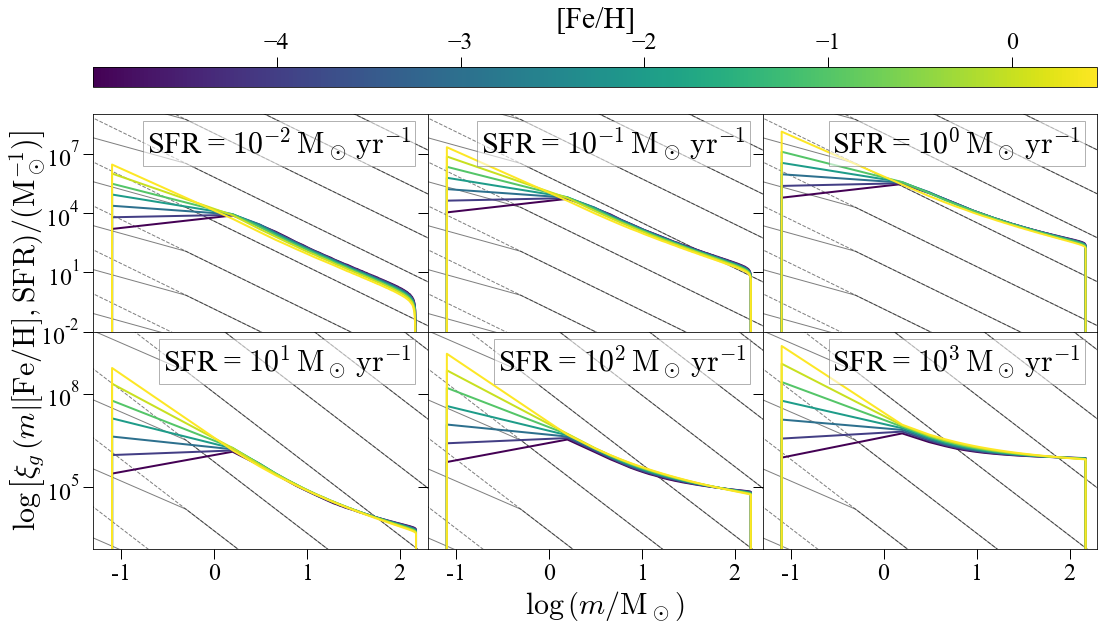

In [50]:
# 2 LINES 3 COLUMNS

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharey='row', sharex=True)#, tight_layout=True)
fig.subplots_adjust(hspace=0, wspace=0) # get rid of white spaces between figures
rect = fig.patch
rect.set_facecolor('white')

flat_fehs = np.concatenate(zsq_plot_fehs)
cnorm = flat_fehs.max()-flat_fehs.min()

col_n = 0
for i, (ax, igimfs, logsfr) in enumerate(zip(axes.flatten(), sfrsq_plot_igimfs, sfrsq_plot_logsfrs)):
    for b in np.logspace(-5, 15, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa(m) for m in ms], 'k-', lw=1, alpha=0.5)
    
    
    fehs = sfrsq_plot_fehs[i]
    for igimf, feh in zip(igimfs, fehs):
        if all(n>=0 for n in igimf):
            c = cm.viridis((np.abs(feh-flat_fehs.min()))/cnorm)
            if feh == 0 and logsfr == 0:
                c = 'red'
            else:
                ax.plot(plot_ms, igimf, label=f'{feh:.2f}', c=c, lw=2)
    ax.set_xscale('log')
    ax.set_yscale('log')

    mini = 0
    for imf in igimf[np.argsort(igimf)]:
        if imf != 0:
            igimf_min = imf
            if mini == 0:
                break
            mini += 1

    if col_n == 0 :
        igmf_min = 1e-1
        igimf_max = 1e9
        ax.set_ylim(igimf_min, igimf_max)
        logticks = np.arange(np.floor(np.log10(igimf_min)), np.floor(np.log10(igimf_max)), 2)
        ax.set_yticks([10.**x for x in logticks])
        ax.set_yticklabels(logticks)
    if col_n == 3:
        igmf_min = 1e-0
        igimf_max = 1e10
        ax.set_ylim(igimf_min, igimf_max)
        logticks = np.arange(np.floor(np.log10(igimf_min)), np.floor(np.log10(igimf_max)), 2)
        ax.set_yticks([10.**x for x in logticks])
        ax.set_yticklabels(logticks)
    col_n += 1
        
    ax.set_xlim(0.05, 200)
    ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
    ax.set_xticks([], minor=True)
    ax.set_xticklabels(np.arange(-1, 3, 1))
    
    sfr_descr = ax.text(0.95, 0.95, f'SFR = $10^{{{logsfr:.0f}}}\,\mathrm{{M}}_\odot\,\mathrm{{yr}}^{{-1}}$', transform=ax.transAxes, ha='right', va='top')
    sfr_descr.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='gray'))

fig.text(0.52, 0.07, r'$\log\left(m/\mathrm{M}_\odot\right)$', ha='center', va='top')#, fontsize=AXIS_FSIZE)
fig.text(0.09, 0.43, r'$\log\left[\xi_g\,\left(m|\mathrm{[Fe/H]},\mathrm{SFR}\right)/(\mathrm{M}_\odot^{-1})\right]$', rotation=90, ha='right', va='center')

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=flat_fehs.min(), vmax=flat_fehs.max()))
cb = fig.colorbar(sm, location='top', aspect=50, ax=axes)
cb.set_label('[Fe/H]')

fig.savefig(FIGURE_FOLDER/'sfr_imfs.pdf', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'sfr_imfs.png', bbox_inches='tight')

In [51]:
[1,2,3,4,5,6][1:-1]

[2, 3, 4, 5]

In [74]:
igmf_min = 1e0
igimf_max = 1e9

In [76]:
igimf_min

55335.57063899045

In [75]:
np.arange(np.floor(np.log10(igimf_min)), np.floor(np.log10(igimf_max)), 2)

array([4., 6., 8.])

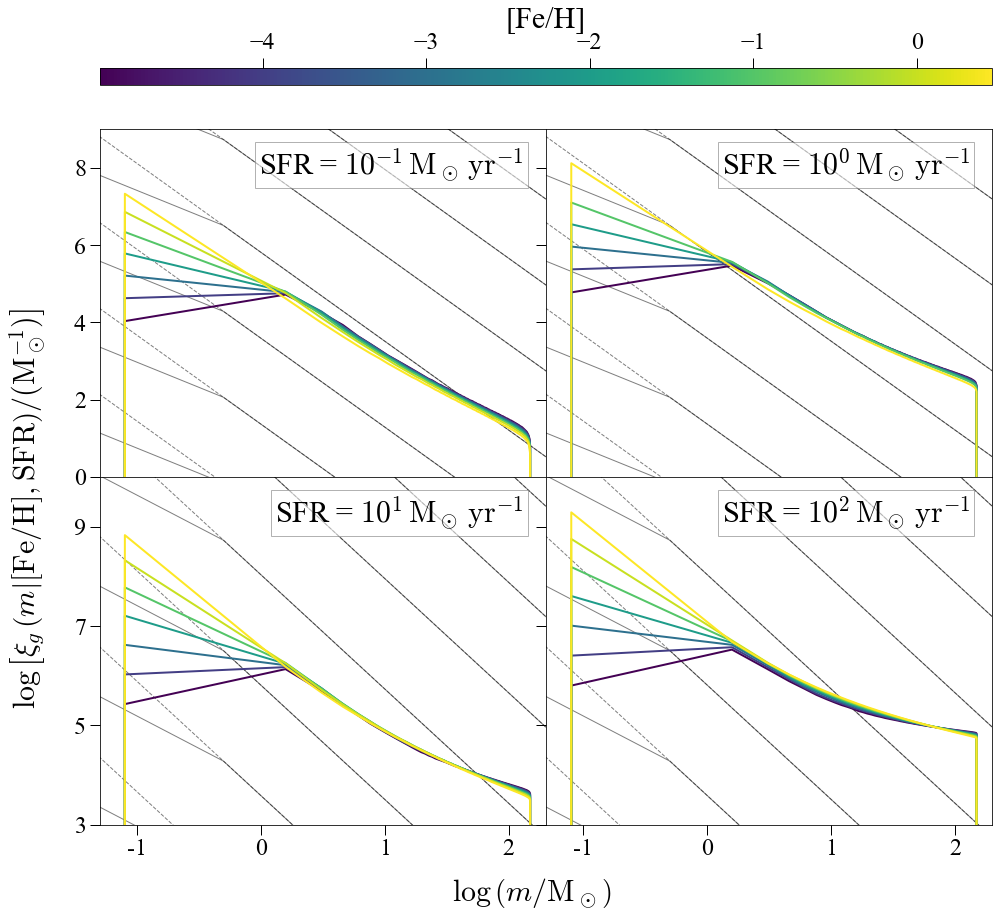

In [87]:
# 2 LINES 3 COLUMNS

fig, axes = plt.subplots(2, 2, figsize=(16, 16), sharey='row', sharex=True)#, tight_layout=True)
fig.subplots_adjust(hspace=0, wspace=0) # get rid of white spaces between figures
rect = fig.patch
rect.set_facecolor('white')

flat_fehs = np.concatenate(zsq_plot_fehs)
cnorm = flat_fehs.max()-flat_fehs.min()

col_n = 0
for i, (ax, igimfs, logsfr) in enumerate(zip(axes.flatten(), sfrsq_plot_igimfs[1:-1], sfrsq_plot_logsfrs[1:-1])):
    for b in np.logspace(-5, 15, 10):
        ms = np.concatenate((np.logspace(-2, np.log10(0.5), 20), np.logspace(np.log10(0.5), 2.5, 21)[1:]))
        ax.plot(ms, 0.5*b*ms**-2.3, 'k--', lw=1, alpha=0.5)
        ax.plot(ms, [0.5*b*kroupa(m) for m in ms], 'k-', lw=1, alpha=0.5)
    
    
    fehs = sfrsq_plot_fehs[i]
    for igimf, feh in zip(igimfs, fehs):
        if all(n>=0 for n in igimf):
            c = cm.viridis((np.abs(feh-flat_fehs.min()))/cnorm)
            if feh == 0 and logsfr == 0:
                c = 'red'
            else:
                ax.plot(plot_ms, igimf, label=f'{feh:.2f}', c=c, lw=2)
    ax.set_xscale('log')
    ax.set_yscale('log')

    mini = 0
    for imf in igimf[np.argsort(igimf)]:
        if imf != 0:
            igimf_min = imf
            if mini == 0:
                break
            mini += 1
       
    ax.set_xlim(0.05, 200)
    ax.set_xticks([10.**x for x in np.arange(-1, 3, 1)])
    ax.set_xticks([], minor=True)
    ax.set_xticklabels(np.arange(-1, 3, 1))
    
    sfr_descr = ax.text(0.95, 0.95, f'SFR = $10^{{{logsfr:.0f}}}\,\mathrm{{M}}_\odot\,\mathrm{{yr}}^{{-1}}$', transform=ax.transAxes, ha='right', va='top')
    sfr_descr.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='gray'))

igimf_min = 1e0
igimf_max = 1e9
axes[0,0].set_ylim(igimf_min, igimf_max)
logticks = np.arange(np.floor(np.log10(igimf_min)), np.floor(np.log10(igimf_max)), 2)
axes[0,0].set_yticks([10.**x for x in logticks])
axes[0,0].set_yticklabels([f'{t:.0f}' for t in logticks])

igimf_min = 1e3
igimf_max = 1e10
axes[1,0].set_ylim(igimf_min, igimf_max)
logticks = np.arange(np.floor(np.log10(igimf_min)), np.floor(np.log10(igimf_max)), 2)
axes[1,0].set_yticks([10.**x for x in logticks])
axes[1,0].set_yticklabels([f'{t:.0f}' for t in logticks])
    
fig.text(0.5, 0.08, r'$\log\left(m/\mathrm{M}_\odot\right)$', ha='center', va='top', transform=fig.transFigure)#, fontsize=AXIS_FSIZE)
fig.text(0.08, 0.4, r'$\log\left[\xi_g\,\left(m|\mathrm{[Fe/H]},\mathrm{SFR}\right)/(\mathrm{M}_\odot^{-1})\right]$', rotation=90, ha='right', va='center', transform=fig.transFigure)

sm = cm.ScalarMappable(cmap=cm.viridis, norm=plt.Normalize(vmin=flat_fehs.min(), vmax=flat_fehs.max()))
cb = fig.colorbar(sm, location='top', aspect=50, ax=axes)
cb.set_label('[Fe/H]')

fig.savefig(FIGURE_FOLDER/'sfr_imfs_square.pdf', bbox_inches='tight')
fig.savefig(FIGURE_FOLDER/'sfr_imfs_square.png', bbox_inches='tight')